## Tallo analysis - 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo.csv')
df_env = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_biome = pd.merge(df, df_env, on='tree_id')

print(df_biome.head(2))

  tree_id    division      family   genus           species  latitude  \
0     T_1  Angiosperm  Betulaceae  Betula  Betula pubescens    67.395   
1     T_2  Gymnosperm    Pinaceae   Picea       Picea abies    67.395   

   longitude  stem_diameter_cm  height_m  crown_radius_m height_outlier  \
0     28.723              10.0       5.6            1.65              N   
1     28.723              10.0       6.6            0.85              N   

  crown_radius_outlier  reference_id       realm                  biome  \
0                    N             1  Palearctic  Boreal/montane forest   
1                    N             1  Palearctic  Boreal/montane forest   

   mean_annual_rainfall  rainfall_seasonality  aridity_index  \
0                   571             32.396118          1.125   
1                   571             32.396120          1.125   

   mean_annual_temperature  maximum_temperature  
0                  -1.2625                 18.1  
1                  -1.2625         

### Make a PFT column that is so far just tropical/extra tropical and broad leaf evergreen

In [4]:
print(df_biome['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
def condition(x) : 
    if x == 'Boreal/montane forest':
        return 'extratrop_tree'
    elif x == 'Tropical rain forest': 
        return 'tropical_tree'
    elif x == 'Temperate broadleaf forest': 
        return 'extratrop_tree'
    elif x == 'Tropical savanna': 
        return 'tropical_tree'
    elif x == 'Tropical dry forest': 
        return 'tropical_tree'
    elif x == 'Temperate grassland': 
        return 'extratrop_tree'
    elif x == 'Temperate conifer forest': 
        return 'extratrop_tree'
    elif x == 'Mediterranean woodland': 
        return 'extratrop_tree'
    elif x == 'Dryland': 
        return 'check'
    elif x == 'Mangrove': 
        return 'check'
    
df_biome['pft1'] = df_biome['biome'].apply(condition)

print(df_biome['pft1'].unique())

['extratrop_tree' 'tropical_tree' 'check']


In [6]:
print(df_biome['latitude'].min())
print(df_biome['latitude'].max())

-51.56
69.88


#### if biome isn't obvious use lat lon

In [7]:
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop_tree'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical_tree'
    else : 
        return  x
    
df_biome['pft1'] = df_biome.apply(lambda row: condition1b(row['pft1'],  row['latitude']), axis=1)


In [8]:
print(df_biome['pft1'].unique())

['extratrop_tree' 'tropical_tree']


In [9]:
def condition2(x) : 
    if x == 'Angiosperm':
        return 'broadleaf'
    elif x == 'Gymnosperm': 
        return 'needleleaf'
   
    
df_biome['pft2'] = df_biome['division'].apply(condition2)

print(df_biome['pft2'].unique())
print(df_biome['division'].unique())

['broadleaf' 'needleleaf' None]
['Angiosperm' 'Gymnosperm' nan]


In [10]:
df_biome['PFT'] = df_biome['pft2'] + '_' + df_biome['pft1']

In [11]:
print(df_biome['PFT'].unique())

['broadleaf_extratrop_tree' 'needleleaf_extratrop_tree'
 'broadleaf_tropical_tree' 'needleleaf_tropical_tree' nan]


### Save the csv file 

In [12]:
df_biome.to_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_PFTs.csv', index=False)


### Plot them  - by PFT

In [13]:
lon_bl_ex  = df_biome.loc[df_biome['PFT'] == 'broadleaf_extratrop_tree','longitude']
lat_bl_ex  = df_biome.loc[df_biome['PFT'] == 'broadleaf_extratrop_tree','latitude']

lon_nl_ex  = df_biome.loc[df_biome['PFT'] == 'needleleaf_extratrop_tree','longitude']
lat_nl_ex  = df_biome.loc[df_biome['PFT'] == 'needleleaf_extratrop_tree','latitude']

lon_bl_tr  = df_biome.loc[df_biome['PFT'] == 'broadleaf_tropical_tree','longitude']
lat_bl_tr  = df_biome.loc[df_biome['PFT'] == 'broadleaf_tropical_tree','latitude']

lon_nl_tr  = df_biome.loc[df_biome['PFT'] == 'broadleaf_tropical_tree','longitude']
lat_nl_tr  = df_biome.loc[df_biome['PFT'] == 'broadleaf_tropical_tree','latitude']


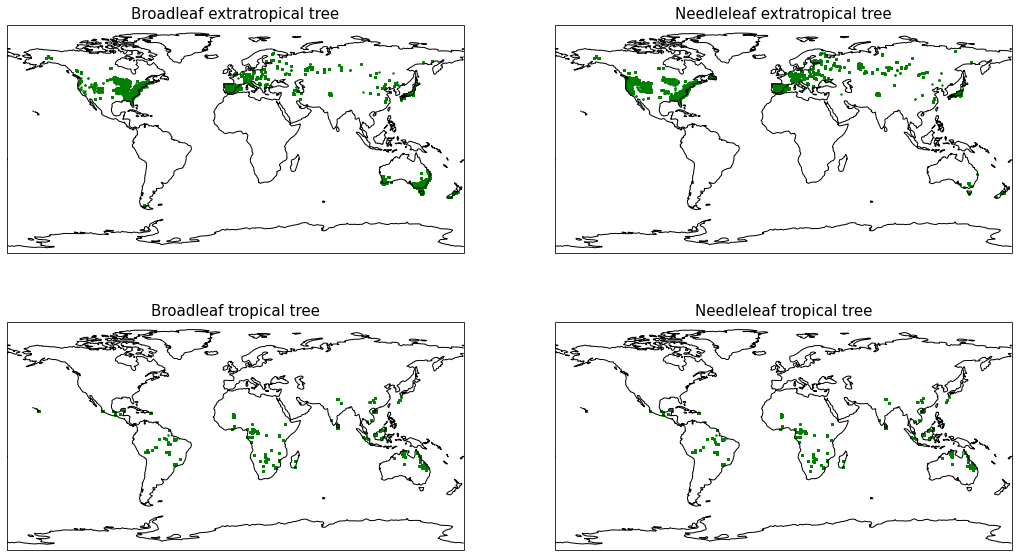

In [15]:
fig1, ((f1ax0,f1ax1),(f1ax2,f1ax3)) = plt.subplots(nrows=2,  ncols=2,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(18,10))

# Extra tropical broadleaf
f1ax0.scatter(lon_bl_ex, lat_bl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf extratropical tree', fontsize=15)

# Extra tropical needleleaf
f1ax1.scatter(lon_nl_ex, lat_nl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Needleleaf extratropical tree', fontsize=15)

# tropical broadleaf
f1ax2.scatter(lon_bl_tr, lat_bl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Broadleaf tropical tree', fontsize=15)

# tropical needleleaf
f1ax3.scatter(lon_nl_tr, lat_nl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()